# Optimized threshold for each output

This script creates an optimized threshold dictionary per output. 

It explores SHERPA studies specifically performed to find the optimal threshold for each output. The ***optimal threshold*** *is the most stringent threshold that allows the CausalNN achieving the minim validation loss (i.e., using two-sig-figures of the mse).*

In addition it plots the NNs' loss (performance) vs complexity (num. of trainable parameters).

## Packages, Modules & Definitions

In [1]:
import sys; sys.path.append("..")

import os, pickle, glob, yaml
import numpy    as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from pathlib import Path
import csv
from math import log10, floor
from sklearn    import preprocessing
from collections import Counter
from os.path import exists
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
def count_inputs(input_list_file):
    c = Counter()
    with open(input_list_file) as f:
        for line in f:
            input = line.strip()
            c[input] += 1
    return c['1']

def calc_parameters(inputs, outputs, nl, nodes):
    l_hidden = [nodes]*nl
    layers   = l_hidden + [outputs]
    parameters = 0
    for iL in range(len(layers)):
        if iL == 0: parameters += ( inputs * layers[iL] + layers[iL] )
        else: parameters += ( layers[iL-1] * layers[iL] + layers[iL] )
    return parameters

def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)


## Options

In [8]:
SHE_alg    = 'GridSearch'
method     = 'sig' # 'sig'; 'aic'
sig        = 2
pdf        = True

## Explore num. of hidden layers and num. of nodes (per layer) with a fixed quantile-thrs (.59)
# SHE_path   = f'./hyperparameter_tuning_{SHE_alg}_SHERPA/'
# SHE_date   = '20220327_'
# # SHE_date   = '20220327_f'
# # SHE_date   = '20220327_phq-'
# # SHE_date   = '20220327_tphystnd-'

## Explore optimal quantile-thrs (.59)
SHE_path   = f'./hyperparameter_tuning_{SHE_alg}_threshold_SHERPA/'
SHE_date   = '202204*_'
# SHE_date   = '20220416_prect'
# SHE_date   = '20220417_f*'
# SHE_date   = '2022041[6,7]_[p,f][r,l,s]*'
# SHE_date   = '20220417_tphystnd-*'
# SHE_date   = '20220417_tphystnd-??.*'
# SHE_date   = '20220417_phq-??.*'
# SHE_date   = '20220417_tphystnd-1??.*'
# SHE_date   = '20220417_phq-1??.*'
# SHE_date   = '20220417_tphystnd-[2,3,4,5,6,7,8,9]??.*'
# SHE_date   = '20220417_phq-[2,3,4,5,6,7,8,9]??.*'
# SHE_date   = '20220417_phq-??.*'
# SHE_date   = '20220417_phq-???.*'
# SHE_date   = '20220417_phq-609.*'
# SHE_date   = '20220417_tphystnd-[1,2,3,4,5,6,7]??.*'
# SHE_date   = '20220417_tphystnd-[1,2,3,5]?.*'
# SHE_date   = '20220417_tphystnd-3.*'
# SHE_date   = '2022041[6,7]_*'
# SHE_date   = '20220417_tphystnd-524.*'

In [9]:
thrsType = 'quantile' if pdf else 'spatially'
outPath = "./nn_config/"+thrsType+"_dicts/"
Path(outPath).mkdir(parents=True, exist_ok=True)
outFile = outPath+f"001_{thrsType}_thresholds_sig-{['aic',sig][method=='sig']}.yml"

## SHERPA Studies

In [10]:
thresholds_dict = {}; thresholds_dict['thresholds_dict'] = {}
loss_complexity_dict = {}
loss       = {'absolute':[],'normalized':[]}
thresholds = []

SHE_studies = glob.glob(SHE_path+SHE_date+'*')

for i, study in enumerate(SHE_studies):
    print(f"Process study: {study}")
    output   = study.split('/')[-1].split('_')[-1]
    
    loss_complexity_dict[output] = {}
    loss_output = []; loss_sig_output = []
    threholds_output = []
    aic_output = []
    num_inputs_output = []
    
    file = open(f"{study}/results.csv")
    csvreader = csv.reader(file)
    
    header = next(csvreader)
#     print(header)
    for row in csvreader:
        if 'COMPLETED' == row[1]:
            
            threshold = row[5]
            input_list_file = glob.glob(study+f"/{row[0]}/*/*/*/*input_list.txt")[0]
            num_inputs      = count_inputs(input_list_file)
#             print(f"{threshold}-thr: {num_inputs} inputs")
            
            cpx = calc_parameters(num_inputs, 1, int(row[3]), int(row[4]))
            aic = 2*num_inputs + 1950*np.log(float(row[-1]))
            loss_complexity_dict[output][row[0]] = {
                 'threshold':threshold,
                'num_inputs':num_inputs,
                'num_layers':int(row[3]),
                 'num_nodes':int(row[4]),
                      'loss':float(row[-1]),
            'loss_round_sig':round_sig(float(row[-1]),sig),
                'complexity':cpx,
                       'aic':aic,
            }
            loss_output.append(float(row[-1]))
            loss_sig_output.append(round_sig(float(row[-1]),sig))
            threholds_output.append(threshold)
            aic_output.append(aic)
            num_inputs_output.append(num_inputs)

    # All output metrics
    loss['absolute'].append(loss_output)
    loss_norm       = preprocessing.minmax_scale(loss_output, feature_range=(0, 1), axis=0, copy=True)
    loss['normalized'].append(loss_norm)
    thresholds.append(threholds_output)

    # Best case
    if method == 'sig':
        loss_output_min = np.min(loss_sig_output)
        best_trials     = [
            (id,i) for i,id in enumerate(loss_complexity_dict[output]) 
            if loss_complexity_dict[output][id]['loss_round_sig'] <= loss_output_min
        ]
        best_thrs  = [(loss_complexity_dict[output][i[0]]['threshold'],i[-1]) for i in best_trials]
        best_trial = best_trials[best_thrs.index(max(best_thrs))]
    elif method == 'aic':
        aic_output      = np.array(aic_output)
        aic_output_min  = np.min(aic_output)
        best_trials     = [
            (id,i) for i,id in enumerate(loss_complexity_dict[output]) 
            if loss_complexity_dict[output][id]['aic'] == aic_output_min
        ]
        best_thrs  = [(loss_complexity_dict[output][i[0]]['threshold'],i[-1]) for i in best_trials]
        best_trial = best_trials[best_thrs.index(min(best_thrs))]
    
    # Best output case
    loss_complexity_dict[output]['best'] = {
              'trial':best_trial[0],
          'threshold':loss_complexity_dict[output][best_trial[0]]['threshold'],
         'num_inputs':loss_complexity_dict[output][best_trial[0]]['num_inputs'],
         'num_layers':loss_complexity_dict[output][best_trial[0]]['num_layers'],
          'num_nodes':loss_complexity_dict[output][best_trial[0]]['num_nodes'],
               'loss':loss_complexity_dict[output][best_trial[0]]['loss'],
     'loss_round_sig':loss_complexity_dict[output][best_trial[0]]['loss_round_sig'],
          'loss_norm':loss_norm[best_trial[-1]],
    }
    
    # Optmized threshold dictionary
    thresholds_dict['thresholds_dict'][output] = \
    float(loss_complexity_dict[output][best_trial[0]]['threshold'])
    
    file.close()
    
loss['absolute']   = np.array(loss['absolute']).flatten()
loss['normalized'] = np.array(loss['normalized']).flatten()
thresholds         = np.array(thresholds).flatten()


# Optmized threshold dictionary: Save?
if not exists(outFile):
    print(f"Create {outFile} dictionary.")
    with open(outFile, 'w') as outfile:
        yaml.dump(thresholds_dict, outfile, default_flow_style=False)
else:
    print(f"{outFile} dictionary exists.")

Process study: ./hyperparameter_tuning_GridSearch_threshold_SHERPA/20220417_flns
Process study: ./hyperparameter_tuning_GridSearch_threshold_SHERPA/20220417_phq-976.33
Process study: ./hyperparameter_tuning_GridSearch_threshold_SHERPA/20220417_phq-957.49
Process study: ./hyperparameter_tuning_GridSearch_threshold_SHERPA/20220417_phq-445.99
Process study: ./hyperparameter_tuning_GridSearch_threshold_SHERPA/20220417_tphystnd-168.23
Process study: ./hyperparameter_tuning_GridSearch_threshold_SHERPA/20220417_fsnt
Process study: ./hyperparameter_tuning_GridSearch_threshold_SHERPA/20220417_phq-14.36
Process study: ./hyperparameter_tuning_GridSearch_threshold_SHERPA/20220417_tphystnd-322.24
Process study: ./hyperparameter_tuning_GridSearch_threshold_SHERPA/20220417_phq-609.78
Process study: ./hyperparameter_tuning_GridSearch_threshold_SHERPA/20220417_phq-691.39
Process study: ./hyperparameter_tuning_GridSearch_threshold_SHERPA/20220417_tphystnd-232.83
Process study: ./hyperparameter_tuning_Gr

## Scatter plot

In [11]:
def loss_complexity_scatter_plot(
    loss_complexity_dict,
    loss,
    thresholds,
    best=True,
    normalized=True,
    title='',
    lims=False,
    save=False,
    savenm=False,
    **kwargs
):
      
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    colors_dict = {
        'flnt':'orange',
        'flns':'orange',
        'fsnt':'chocolate',
        'fsns':'chocolate',
#          'phq':'steelblue',
         'phq':'indigo',
       'prect':'b',
    'tphystnd':'r',
    }
    markers_dict = {        
        1:'1',2:'2',3:'3',4:'>',5:'<',6:'^',7:'v',8:'+',9:'*',10:'.',
    }

    lims = lims if lims else 1
    
    # Normalization [0,1]? Note different outputs will have different loss.
    if normalized:
        loss = loss['normalized']
    else:
#         loss = np.log(loss['absolute'])
        loss = loss['absolute']
    
    # Scatter Plot
    ax.scatter(
        thresholds,
        loss,
        color='grey',
    )

    # Best outputs case
    if best:
        for output in sorted(loss_complexity_dict):
            if normalized:
                loss       = loss_complexity_dict[output]['best']['loss_norm']
            else:
#                 loss       = loss_complexity_dict[output]['best']['loss_round_sig']
                loss       = loss_complexity_dict[output]['best']['loss']
#                 loss = np.log(loss_complexity_dict[output]['best']['loss'])
            threshold  = loss_complexity_dict[output]['best']['threshold']
            num_inputs = loss_complexity_dict[output]['best']['num_inputs']
            color  = colors_dict[output.split('-')[0]]
            marker = markers_dict[loss_complexity_dict[output]['best']['num_layers']]
            ax.scatter(
                threshold,
                loss,
                color=color,
                marker=marker,
                label=output+f" ({threshold}: {num_inputs})",
                alpha=.8,
            )
    
    # Attributes
    # Make a plot with major ticks that are multiples of 20 and minor ticks that
    # are multiples of 5.  Label major ticks with '%d' formatting but don't label
    # minor ticks.
    ax.xaxis.set_major_locator(MultipleLocator(2))

#     if lims != False:
#         ax.set_xlim(-.01, lims); ax.set_ylim(-.01, lims)
#         ax.axline((-.01,lims) ,(lims, -.01), color='k', linestyle='--')
#     else:
#         ax.axline((0,lims) ,(lims, 0), color='k', linestyle='--')

    if normalized:
        ax.set_ylabel("Normalized loss (mse)"); ax.set_xlabel("Thresholds")
    else:
        ax.set_ylabel("Loss (mse)"); ax.set_xlabel("Thresholds")
        ax.set_yscale('log')
#     ax.legend(ncol=3,fontsize='medium',bbox_to_anchor=(.5, -.5), loc='lower center')

    # Save fig
    fig.suptitle(title)
    if save is not False:
        Path(save).mkdir(parents=True, exist_ok=True)
        savenm = f'{statsnm}_single_level-{idx_lab}_nTime-{nTime}.png' if not savenm else savenm
        fig.savefig(f"{save}/{savenm}",dpi=1000.)
        print(f"{save}/{savenm}")

#         # Legend: colors & markers
#         fig_aux = plt.figure(figsize=(5, 5))
#         if best:
#             for output in sorted(loss_complexity_dict):
#                 if normalized:
#                     loss       = loss_complexity_dict[output]['best']['loss_norm']
#                 else:
#                     loss       = loss_complexity_dict[output]['best']['loss']
#                 threshold  = loss_complexity_dict[output]['best']['threshold']
#                 num_inputs = loss_complexity_dict[output]['best']['num_inputs']
#                 color  = colors_dict[output.split('-')[0]]
#                 marker = markers_dict[loss_complexity_dict[output]['best']['num_layers']]
#                 ax.scatter(
#                     threshold,
#                     loss,
#                     color=color,
#                     marker=marker,
#                     label=output+f" ({threshold}: {num_inputs})",
#                     alpha=.8,
#                 )
        
#         for j, jKey in enumerate({**colors_dict, **markers_dict}):
#             color = colors_dict[jKey] if jKey > 10 else 'k'
#             marker=markers_dict[jKey] if jKey < 10 else 'o'
#             lab   = 'nodes-'+str(jKey) if jKey > 10 else 'hl-'+str(jKey)
#             plt.scatter(
#                 -100.,-100.,
#                 label=lab,
#                 alpha=.8,
#                 color=color,
#                 marker=marker,
#                 s=50,
#             )

#         plt.xlim(0, 10)
#         plt.ylim(0, 10)
#         plt.legend(ncol=3,fontsize='medium',loc='center',frameon=False)
#         fig_aux.savefig(f"{save}/legend_aux.png",dpi=1000.)
            
    plt.show()

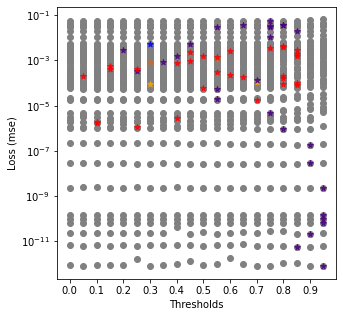

In [12]:
normalized=False # False; True
loss_complexity_scatter_plot(
    loss_complexity_dict,
    loss,
    thresholds,
    best=True,
    normalized=normalized,
#     lims=.5,
#     save='./plots', savenm=f"{SHE_path.split('/')[1]}_all-outputs_sig-{['aic',sig][method=='sig']}_norm-{normalized}.png",
#     save='./plots', savenm=f"{SHE_path.split('/')[1]}_prect_sig-{['aic',sig][method=='sig']}_norm-{normalized}.png",
#     save='./plots', savenm=f"{SHE_path.split('/')[1]}_rad_sig-{['aic',sig][method=='sig']}_norm-{normalized}.png",
#     save='./plots', savenm=f"{SHE_path.split('/')[1]}_dTdt-3hPa-87hPa_sig-{['aic',sig][method=='sig']}_norm-{normalized}.png",
#     save='./plots', savenm=f"{SHE_path.split('/')[1]}_dQdt-3hPa-87hPa_sig-{['aic',sig][method=='sig']}_norm-{normalized}.png",
#     save='./plots', savenm=f"{SHE_path.split('/')[1]}_dTdt-100hPa-197hPa_sig-{['aic',sig][method=='sig']}_norm-{normalized}.png",
#     save='./plots', savenm=f"{SHE_path.split('/')[1]}_dQdt-100hPa-197hPa_sig-{['aic',sig][method=='sig']}_norm-{normalized}.png",
#     save='./plots', savenm=f"{SHE_path.split('/')[1]}_dTdt-200hPa-992hPa_sig-{['aic',sig][method=='sig']}_norm-{normalized}.png",
#     save='./plots', savenm=f"{SHE_path.split('/')[1]}_dQdt-200hPa-992hPa_sig-{['aic',sig][method=='sig']}_norm-{normalized}.png",
)